# <font color='orange'>Amazon Fine Food Reviews Analysis</font>


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. <font color='orange'>Reading Data</font>

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 Order By Time LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] <font color='orange'>Exploratory Data Analysis</font>

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

### <font color='orange'>Sorting according to Time</font>

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(68777, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

68.777

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(68775, 10)


1    60763
0     8012
Name: Score, dtype: int64

#  [3] <font color='orange'>Preprocessing</font>

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I sent this plant to my sister when she moved into her new house for a new job.  I can't guarantee the fortune or luck, but my sister loves the Tree! It was her favorite house/job warming gift.  It's still really healthy now and has even grown some.  It was also delivered on the day after she moved in exactly as I asked.  Really good customer service and products, highly recommend.  Thanks again!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I sent this plant to my sister when she moved into her new house for a new job.  I can't guarantee the fortune or luck, but my sister loves the Tree! It was her favorite house/job warming gift.  It's still really healthy now and has even grown some.  It was also delivered on the day after she moved in exactly as I asked.  Really good customer service and products, highly recommend.  Thanks again!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and 

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the best hot chocolate I first tried this in California and hoped that one day I could find it at a local market I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 68775/68775 [00:35<00:00, 1943.62it/s]


In [23]:
preprocessed_reviews[1500]

'best hot chocolate first tried california hoped one day could find local market excited find amazon get shipped gifts husband'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [ ]:
## Similartly you can do preprocessing for review summary also.

# [4] <font color='orange'>Featurization</font>

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] <font color='orange'>Assignment 7: SVM</font>

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] <font color='orange'>Linear SVM</font>

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [24]:
# Please write all the code with proper documentation

In [25]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test


X = preprocessed_reviews
y = final['Score']
data=pd.DataFrame(preprocessed_reviews,columns=['review'])
data['score']=final['Score']
X_train, X_test= np.split(data, [int(.67 *len(X))])

X_train1=X_train
X_test1=X_test
print('length of X_train:',len(X_train),'length of X_test:',len(X_test))

length of X_train: 46079 length of X_test: 22696


In [26]:
#BoW

count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train['review'])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train['review'])
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

final_test=count_vect.transform(X_test['review'])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaah', 'aaaaah', 'aaah', 'aaahs', 'aachen', 'aad']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46079, 40812)
the number of unique words  40812


In [27]:
# Shape of train and test data
print("X_train shape: {0} ".format(len(X_train)))
print("X_test shape:  {0} ".format(len(X_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 46079 
X_test shape:  22696 

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [28]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(final_counts)


In [29]:
final_tst=stdslr.transform(final_test)

In [30]:
X_train=final_cnt
X_test=final_tst

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 46079 
y_test shape:  22696 


## k-fold Cross Validation

In [31]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
cv_list=[]
# alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp, tol=1e-3,class_weight='balanced')  
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

100%|██████████| 10/10 [00:15<00:00,  1.06it/s]


In [32]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-5)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.8435637029320127, 0.843513626483006, 0.8429366644443359, 0.860751844546917, 0.8894081372042926, 0.9088414118893262, 0.9163677032326174, 0.9010042543897017, 0.8957347192817184, 0.8957339065247296]
Maximum auc is:  0.9163677032326174 for alpha= 10.0


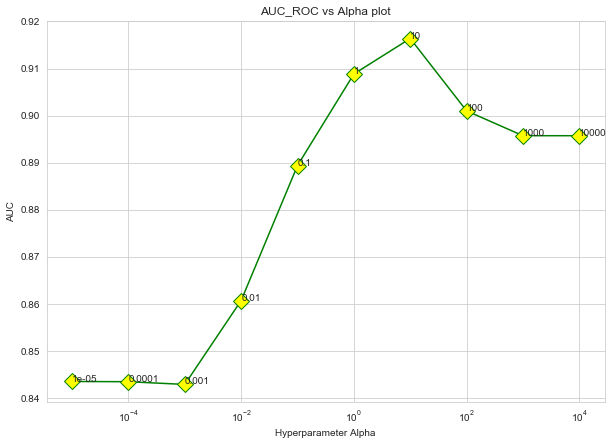

In [33]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

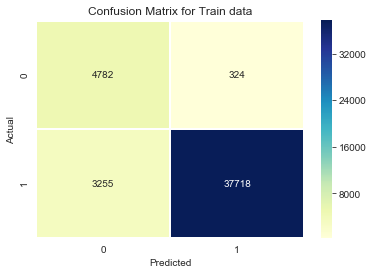

In [34]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3, class_weight='balanced')  
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_train,svm_optimal.predict(X_train))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

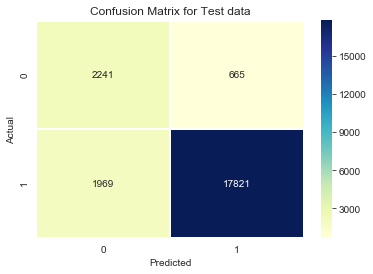

In [35]:
import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3, class_weight='balanced')  
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,svm_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [36]:
# calculating train_auc
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp,class_weight='balanced', tol=1e-3)  
    clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)
    

100%|██████████| 10/10 [00:13<00:00,  1.08it/s]


In [37]:
# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp,class_weight='balanced', tol=1e-3)  
    clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)

100%|██████████| 10/10 [00:15<00:00,  1.08s/it]


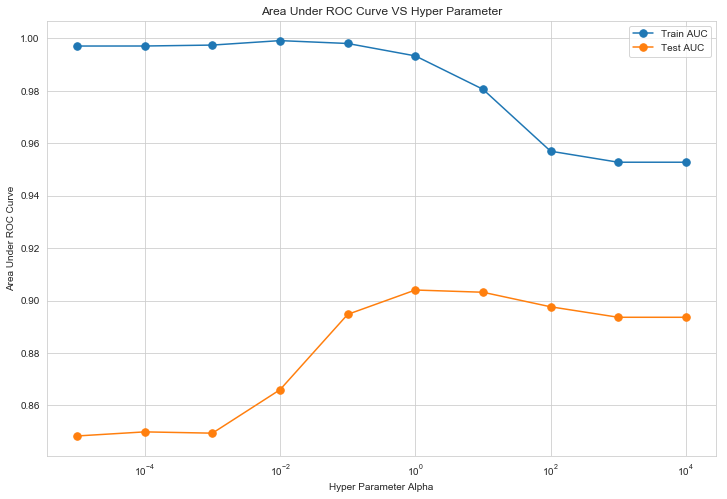

In [38]:
plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [39]:
sv_optimal=linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3,class_weight='balanced') 
sv_optimal = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
sv_optimal.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10000, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid'),
            cv=5, method='sigmoid')

Train AUC: 0.951095
Test AUC: 0.891944


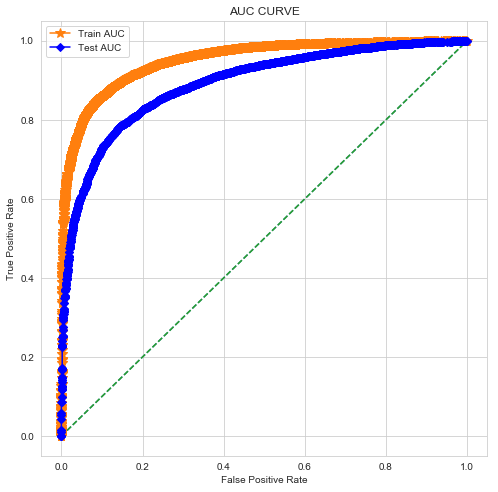

In [40]:
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = sv_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = sv_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()

## Conclusion

In [41]:
bow_brute_par=opt_alpha
bow_brute_auc=np.round(test_auc,4)
print("Vectorizer: BOW \t Model: SVM")
print("Best Hyper parameter: ",bow_brute_par)
print("AUC: ",bow_brute_auc)

Vectorizer: BOW 	 Model: SVM
Best Hyper parameter:  10.0
AUC:  0.8919


### Feature Importance on BOW, SET 1

In [42]:
words=count_vect.get_feature_names()
clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp, tol=1e-3,class_weight='balanced') 
clf.fit(X_train,y_train)
coef=clf.coef_.tolist()[0]
coef=np.array(coef).T.tolist()
df_coef=pd.DataFrame({'words':words,'coef':coef})
df_coef1=df_coef.sort_values(['coef', 'words'], ascending=[0, 1])

### Top 10 important features of positive class from SET 1

In [43]:
print('Top 10 feature from Positive class')
print(df_coef1.head(10).to_string(index=False))

Top 10 feature from Positive class
     words      coef
     great  0.000020
      best  0.000015
 delicious  0.000012
      love  0.000011
   perfect  0.000010
  favorite  0.000010
 wonderful  0.000010
    highly  0.000010
     loves  0.000009
 excellent  0.000009


### Top 10 important features of negative class from SET 1

In [44]:
print('Top 10 feature from Negative class')        
print(df_coef1.tail(10).to_string(index=False))

Top 10 feature from Negative class
        words      coef
       return -0.000018
          bad -0.000018
     horrible -0.000019
     terrible -0.000019
        awful -0.000019
        money -0.000019
        threw -0.000020
 disappointed -0.000020
        worst -0.000020
          not -0.000024


### [5.1.2] <font color='orange'>Applying Linear SVM on TFIDF</font>,<font color='red'> SET 2</font>

In [45]:
# Please write all the code with proper documentation

In [46]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test


X = preprocessed_reviews
y = final['Score']
data=pd.DataFrame(preprocessed_reviews,columns=['review'])
data['score']=final['Score']
X_train, X_test= np.split(data, [int(.67 *len(X))])

X_train1=X_train
X_test1=X_test
print('length of X_train:',len(X_train),'length of X_test:',len(X_test))

length of X_train: 46079 length of X_test: 22696


In [47]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit(X_train['review'])
X_train_tfidf= tf_idf_vect.transform(X_train['review'])

X_test_tfidf=tf_idf_vect.transform(X_test['review'])

In [48]:
# Shape of train and test data
print("X_train shape: {0} ".format(len(X_train)))
print("X_test shape:  {0} ".format(len(X_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 46079 
X_test shape:  22696 

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [49]:
final_counts=X_train_tfidf
final_test=X_test_tfidf

In [50]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(final_counts)
final_tst=stdslr.transform(final_test)

In [51]:
X_train=final_cnt
X_test=final_tst

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 46079 
y_test shape:  22696 


## k-fold Cross Validation

In [52]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
cv_list=[]
# alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp, tol=1e-3,class_weight='balanced')  
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

100%|██████████| 10/10 [00:13<00:00,  1.10s/it]


In [53]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-5)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.8827378155572786, 0.8826551777125775, 0.8823509390144061, 0.8852813905156195, 0.903566133746397, 0.9176820379088078, 0.941501562868544, 0.9352860358998057, 0.9353138737181433, 0.9353135630033341]
Maximum auc is:  0.941501562868544 for alpha= 10.0


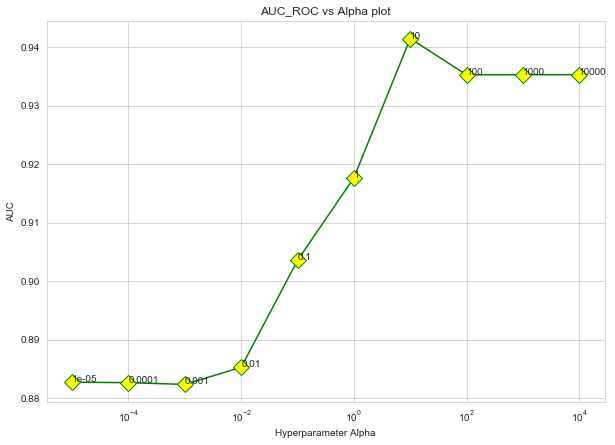

In [55]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

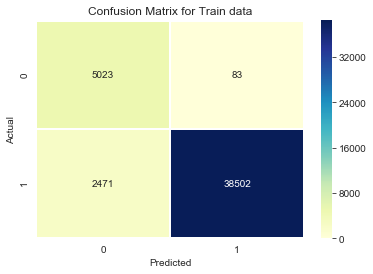

In [56]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3, class_weight='balanced')  
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_train,svm_optimal.predict(X_train))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

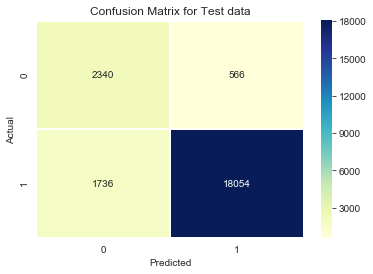

In [57]:
import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3, class_weight='balanced')  
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,svm_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [58]:
# calculating train_auc
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp,class_weight='balanced', tol=1e-3)  
    clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)
    

100%|██████████| 10/10 [00:13<00:00,  1.13s/it]


In [59]:
# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp,class_weight='balanced', tol=1e-3)  
    clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)

100%|██████████| 10/10 [00:13<00:00,  1.11s/it]


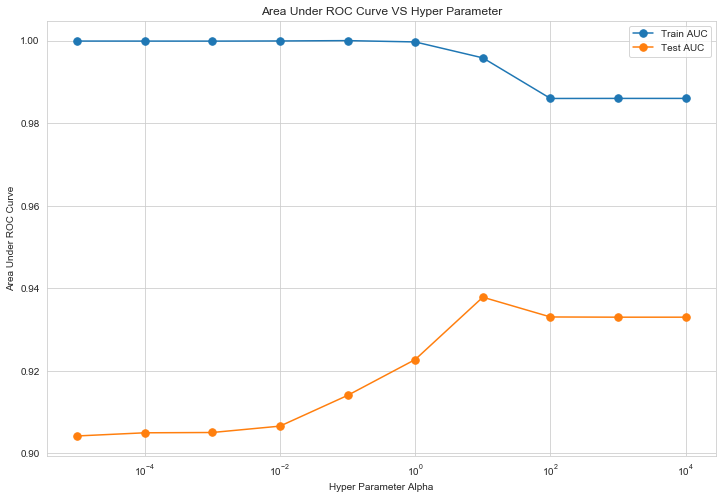

In [60]:
plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [61]:
sv_optimal=linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3,class_weight='balanced') 
sv_optimal = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
sv_optimal.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10000, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid'),
            cv=5, method='sigmoid')

Train AUC: 0.986607
Test AUC: 0.932626


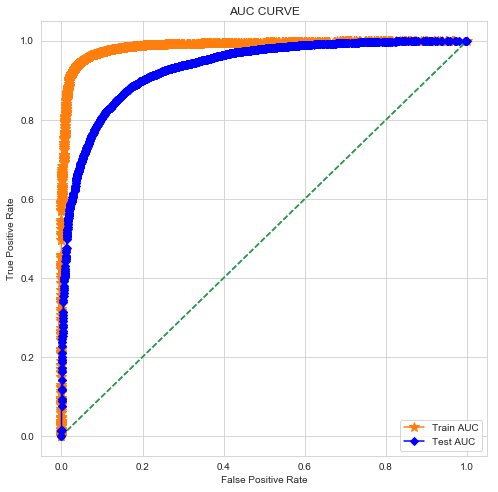

In [62]:
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = sv_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = sv_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()

## Conclusion

In [63]:
tfidf_brute_par=opt_alpha
tfidf_brute_auc=np.round(test_auc,4)
print("Vectorizer: TFIDF \t Model: SVM")
print("Best Hyper parameter: ",tfidf_brute_par)
print("AUC: ",tfidf_brute_auc)

Vectorizer: TFIDF 	 Model: SVM
Best Hyper parameter:  10.0
AUC:  0.9326


### Feature Importance on TFIDF, SET 1

In [64]:
words=tf_idf_vect.get_feature_names()
clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp, tol=1e-3,class_weight='balanced') 
clf.fit(X_train,y_train)
coef=clf.coef_.tolist()[0]
coef=np.array(coef).T.tolist()
df_coef=pd.DataFrame({'words':words,'coef':coef})
df_coef1=df_coef.sort_values(['coef', 'words'], ascending=[0, 1])

### Top 10 important features of positive class from SET 1

In [65]:
print('Top 10 feature from Positive class')
print(df_coef1.head(10).to_string(index=False))

Top 10 feature from Positive class
     words      coef
     great  0.000020
      best  0.000015
      love  0.000013
 delicious  0.000012
  favorite  0.000010
   perfect  0.000010
 wonderful  0.000010
    highly  0.000010
     loves  0.000009
      easy  0.000009


### Top 10 important features of negative class from SET 1

In [66]:
print('Top 10 feature from Negative class')        
print(df_coef1.tail(10).to_string(index=False))

Top 10 feature from Negative class
        words      coef
        waste -0.000019
    would not -0.000019
  waste money -0.000020
     terrible -0.000020
        awful -0.000020
        threw -0.000020
 disappointed -0.000021
      not buy -0.000021
        worst -0.000022
          not -0.000034


### [5.1.3]  <font color='orange'>Applying Linear SVM on AVG W2V</font>,<font color='red'> SET 3</font>

In [67]:
# Please write all the code with proper documentation

In [68]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test
from sklearn.model_selection import train_test_split

X = preprocessed_reviews
y = final['Score']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test= np.split(X, [int(.67 *len(X))])

print('shape of X_train:',len(X_train),'shape of X_test:',len(X_test))

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test

shape of X_train: 46079 shape of X_test: 22696


In [69]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [70]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8080600500106812), ('excellent', 0.8064738512039185), ('terrific', 0.8062340021133423), ('fantastic', 0.79339599609375), ('wonderful', 0.7914190292358398), ('good', 0.7632894515991211), ('amazing', 0.7209535837173462), ('incredible', 0.7089407444000244), ('perfect', 0.7079124450683594), ('fabulous', 0.6824066638946533)]
[('greatest', 0.7745424509048462), ('best', 0.7627947330474854), ('closest', 0.6485645771026611), ('truer', 0.6453489065170288), ('awful', 0.6438285708427429), ('disgusting', 0.640658974647522), ('seen', 0.634800136089325), ('tastiest', 0.6280921697616577), ('experienced', 0.6268789172172546), ('imagined', 0.5873695611953735)]


In [71]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
print(len(w2v_words))
# length=len(w2v_words)

number of words that occured minimum 5 times  13183
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children']
13183


In [72]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
sent_vectors=np.array(sent_vectors)

100%|██████████| 46079/46079 [01:55<00:00, 398.75it/s]


46079
50


In [73]:
sent_vec_test=[]
sentance_test=[]
for sentance in X_test:
    sentance_test.append(sentance.split())
    

for sent in tqdm(sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vec_test.append(sent_vec)
print(len(sent_vec_test))
print(len(sent_vec_test[0]))
sent_vec_test=np.array(sent_vec_test)

100%|██████████| 22696/22696 [01:11<00:00, 316.33it/s]

22696
50


In [74]:
# Shape of train and test data
print("X_train shape: {0}   y_train shape: {1}".format(len(X_train), len(y_train)))
print("X_test shape:  {0}    y_test shape: {1}".format(len(X_test), len(y_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 46079   y_train shape: 46079
X_test shape:  22696    y_test shape: 22696

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [75]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(sent_vectors)
final_tst=stdslr.transform(sent_vec_test)

In [76]:
X_train=final_cnt
X_test=final_tst

## k-fold Cross Validation

In [77]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
cv_list=[]
# alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp, tol=1e-3,class_weight='balanced')  
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

100%|██████████| 10/10 [00:14<00:00,  1.26it/s]


In [78]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-5)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.8548961104069107, 0.8743571498851574, 0.8871261212888599, 0.8887863466432799, 0.8864239198132344, 0.8689653244871287, 0.7993622268828962, 0.83690758965968, 0.8369071356222871, 0.8369075655313353]
Maximum auc is:  0.8887863466432799 for alpha= 0.01


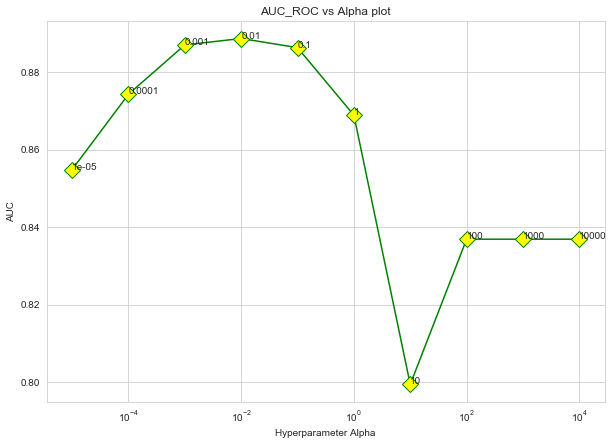

In [79]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

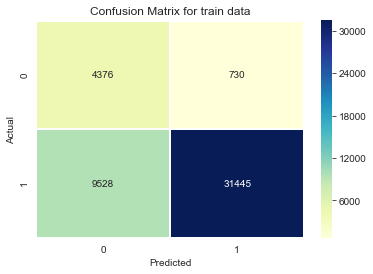

In [80]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3, class_weight='balanced')  
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_train,svm_optimal.predict(X_train))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

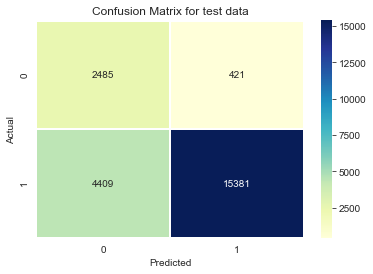

In [81]:
import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3, class_weight='balanced')  
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,svm_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [82]:
# calculating train_auc
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp,class_weight='balanced', tol=1e-3)  
    clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)
    

100%|██████████| 10/10 [00:16<00:00,  1.03s/it]


In [83]:
# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp,class_weight='balanced', tol=1e-3)  
    clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)

100%|██████████| 10/10 [00:18<00:00,  1.03s/it]


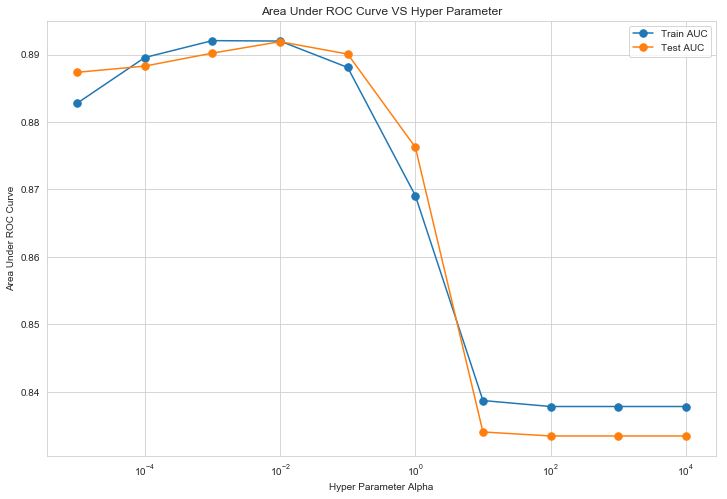

In [84]:
plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [85]:
sv_optimal=linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3,class_weight='balanced') 
sv_optimal = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
sv_optimal.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10000, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid'),
            cv=5, method='sigmoid')

Train AUC: 0.837854
Test AUC: 0.833519


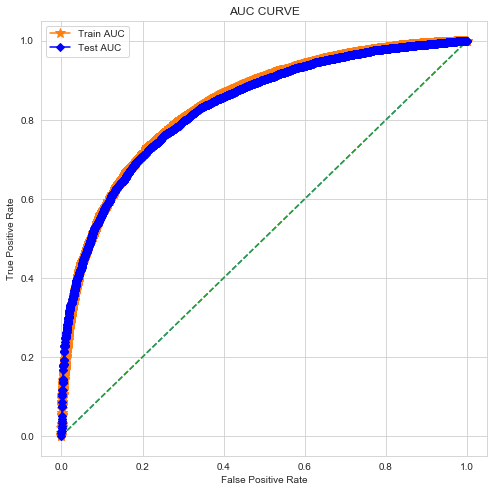

In [86]:
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = sv_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = sv_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()

## Conclusion

In [87]:
avgwv_brute_par=opt_alpha
avgwv_brute_auc=np.round(test_auc,4)
print("Vectorizer: AVG W2V \t Model: SVM")
print("Best Hyper parameter: ",avgwv_brute_par)
print("AUC: ",avgwv_brute_auc)

Vectorizer: AVG W2V 	 Model: SVM
Best Hyper parameter:  0.01
AUC:  0.8335


### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [88]:
# Please write all the code with proper documentation

In [89]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test
# from sklearn.model_selection import train_test_split

X = preprocessed_reviews
y = final['Score']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test= np.split(X, [int(.67 *len(X))])

print('shape of X_train:',len(X_train),'shape of X_test:',len(X_test))

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test

shape of X_train: 46079 shape of X_test: 22696


In [90]:
# Shape of train and test data
print("X_train shape: {0}   y_train shape: {1}".format(len(X_train), len(y_train)))
print("X_test shape:  {0}    y_test shape: {1}".format(len(X_test), len(y_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 46079   y_train shape: 46079
X_test shape:  22696    y_test shape: 22696

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [91]:
model = TfidfVectorizer(min_df=10,max_features=1000)
tf_idf_matrix = model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 46079/46079 [02:28<00:00, 310.45it/s]


In [92]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 22696/22696 [01:17<00:00, 293.58it/s]


In [93]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(tfidf_sent_vectors_train)
final_tst=stdslr.transform(tfidf_sent_vectors_test)

In [94]:
X_train=final_cnt
X_test=final_tst

## k-fold Cross Validation

In [95]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
cv_list=[]
# alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp, tol=1e-3,class_weight='balanced')  
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

100%|██████████| 10/10 [00:14<00:00,  1.28it/s]


In [96]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-5)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.8134153886446732, 0.8216993991849305, 0.8469806292351432, 0.8520722577413424, 0.8468886144135048, 0.8167747675755586, 0.7841361036317025, 0.7399978661770454, 0.7841283319228218, 0.7841277106278547]
Maximum auc is:  0.8520722577413424 for alpha= 0.01


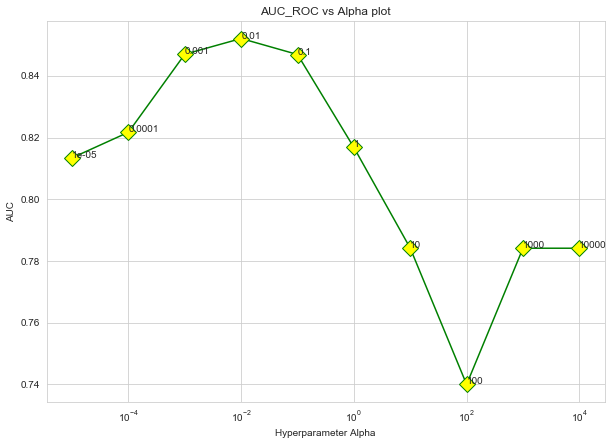

In [97]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

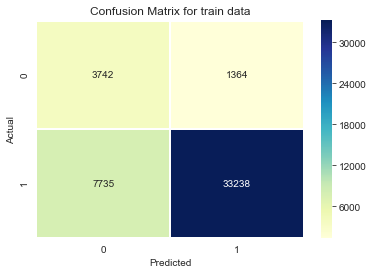

In [98]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3, class_weight='balanced')  
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_train,svm_optimal.predict(X_train))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

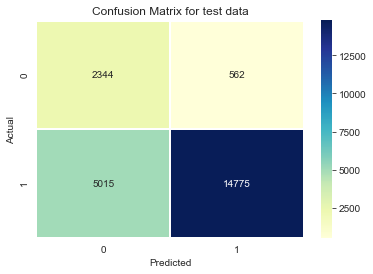

In [99]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3, class_weight='balanced')  
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,svm_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [100]:
# calculating train_auc
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp,class_weight='balanced', tol=1e-3)  
    clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)
    

100%|██████████| 10/10 [00:14<00:00,  1.24it/s]


In [101]:
# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in tqdm(alpha_list):
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp,class_weight='balanced', tol=1e-3)  
    clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)

100%|██████████| 10/10 [00:15<00:00,  1.13it/s]


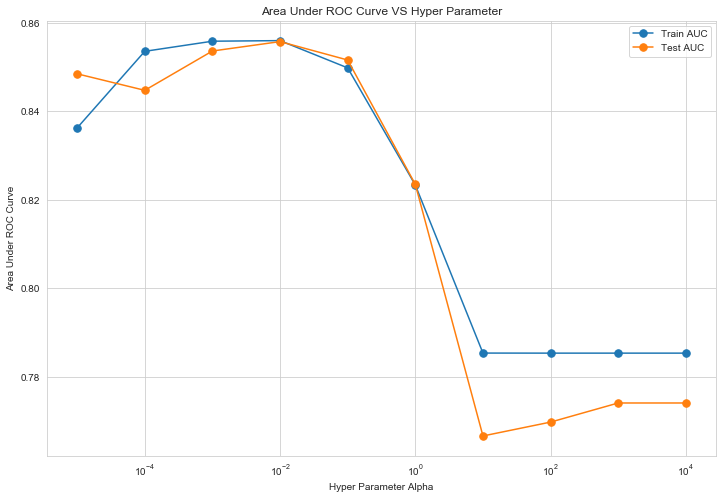

In [102]:
plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [103]:
sv_optimal=linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp, tol=1e-3,class_weight='balanced') 
sv_optimal = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
sv_optimal.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10000, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid'),
            cv=5, method='sigmoid')

Train AUC: 0.785438
Test AUC: 0.774259


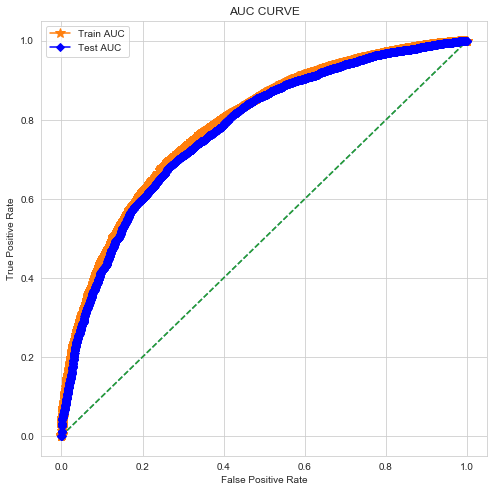

In [104]:
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = sv_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = sv_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()

## Conclusion

In [105]:
tfidfwv_brute_par=opt_alpha
tfidfwv_brute_auc=np.round(test_auc,4)
print("Vectorizer: TFIDF W2V \t Model: SVM ")
print("Best Hyper parameter: ",tfidfwv_brute_par)
print("AUC: ",tfidfwv_brute_auc)

Vectorizer: TFIDF W2V 	 Model: SVM 
Best Hyper parameter:  0.01
AUC:  0.7743


## [5.2] <font color='orange'>RBF SVM</font>

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [106]:
# Please write all the code with proper documentation

In [107]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test


X = preprocessed_reviews
y = final['Score']

X=X[0:20000]
y=y[0:20000]

data=pd.DataFrame(X,columns=['review'])
data['score']=y
X_train, X_test= np.split(data, [int(.67 *len(X))])

X_train1=X_train
X_test1=X_test
print('length of X_train:',len(X_train),'length of X_test:',len(X_test))

length of X_train: 13400 length of X_test: 6600


In [108]:
#BoW

count_vect = CountVectorizer(min_df=10,max_features=500) #in scikit-learn
count_vect.fit(X_train['review'])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train['review'])
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

final_test=count_vect.transform(X_test['review'])

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'ago', 'almost', 'along', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (13400, 500)
the number of unique words  500


In [109]:
# Shape of train and test data
print("X_train shape: {0} ".format(len(X_train)))
print("X_test shape:  {0} ".format(len(X_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 13400 
X_test shape:  6600 

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [110]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(final_counts)
final_tst=stdslr.transform(final_test)

In [111]:
X_train=final_cnt
X_test=final_tst

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 13400 
y_test shape:  6600 


## k-fold Cross Validation

In [112]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
cv_list=[]
alpha_list=[10 ** x for x in range(-4, 4)]
for alp in tqdm(alpha_list):
    clf = SVC(C=alp, kernel='rbf',class_weight='balanced')
    scores=cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc') 
    cv_list.append(scores.mean())
    

100%|██████████| 8/8 [05:47<00:00, 33.99s/it]


In [113]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-4)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.6870905465633323, 0.6870905465633323, 0.6870905465633323, 0.8618521411587127, 0.8694656774890577, 0.8569549727300241, 0.8324242461639088, 0.8041922423312061]
Maximum auc is:  0.8694656774890577 for alpha= 1.0


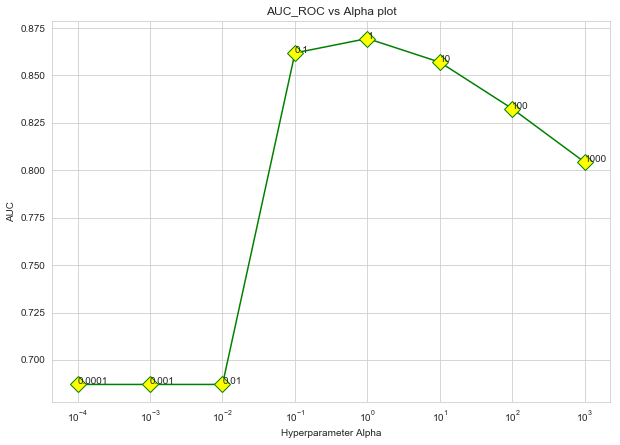

In [114]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

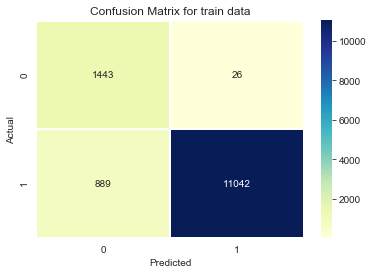

In [115]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = SVC(C=opt_alpha, kernel='rbf',class_weight='balanced')
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_train,svm_optimal.predict(X_train))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

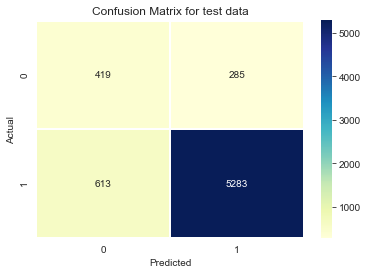

In [116]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = SVC(C=opt_alpha, kernel='rbf',class_weight='balanced')
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,svm_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [117]:
# calculating train_auc
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-4, 4)]
for alp in tqdm(alpha_list):
    clf = SVC(C=alp, kernel='rbf',probability=True,class_weight='balanced')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)
    

100%|██████████| 8/8 [21:02<00:00, 131.43s/it]


In [118]:
# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-4, 4)]
for alp in tqdm(alpha_list):
    clf = SVC(C=alp, kernel='rbf',probability=True,class_weight='balanced')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)

100%|██████████| 8/8 [21:14<00:00, 122.89s/it]


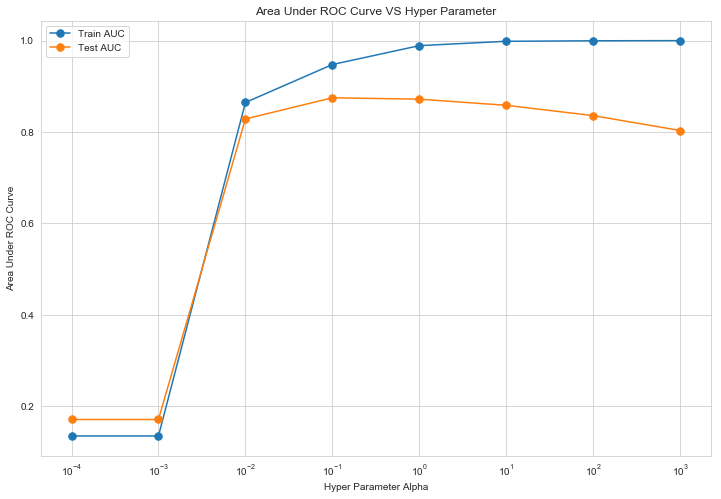

In [119]:
plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [120]:
sv_optimal=SVC(C=opt_alpha, kernel='rbf',probability=True,class_weight='balanced')
sv_optimal.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Train AUC: 0.988927
Test AUC: 0.871850


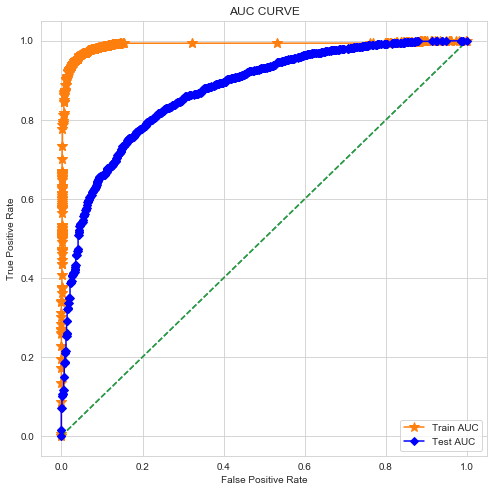

In [121]:
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = sv_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = sv_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()

## Conclusion

In [122]:
bow_brute_par2=opt_alpha
bow_brute_auc2=np.round(test_auc,4)
print("Vectorizer: BOW \t Model: SVM with RBF KERNEL")
print("Best Hyper parameter: ",bow_brute_par2)
print("AUC: ",bow_brute_auc2)

Vectorizer: BOW 	 Model: SVM with RBF KERNEL
Best Hyper parameter:  1.0
AUC:  0.8718


### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [123]:
# Please write all the code with proper documentation

In [124]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test


X = preprocessed_reviews
y = final['Score']
X=X[0:20000]
y=y[0:20000]
data=pd.DataFrame(X,columns=['review'])
data['score']=y
X_train, X_test= np.split(data, [int(.67 *len(X))])

X_train1=X_train
X_test1=X_test
print('length of X_train:',len(X_train),'length of X_test:',len(X_test))

length of X_train: 13400 length of X_test: 6600


In [125]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5,max_features=500)
tf_idf_vect.fit(X_train['review'])
X_train_tfidf= tf_idf_vect.transform(X_train['review'])

X_test_tfidf=tf_idf_vect.transform(X_test['review'])

In [126]:
# Shape of train and test data
print("X_train shape: {0} ".format(len(X_train)))
print("X_test shape:  {0} ".format(len(X_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 13400 
X_test shape:  6600 

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [127]:
final_counts=X_train_tfidf
final_test=X_test_tfidf

In [128]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(final_counts)
final_tst=stdslr.transform(final_test)

In [129]:
X_train=final_cnt
X_test=final_tst

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 13400 
y_test shape:  6600 


## k-fold Cross Validation

In [130]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
cv_list=[]
alpha_list=[10 ** x for x in range(-4, 4)]
for alp in tqdm(alpha_list):
    clf = SVC(C=alp, kernel='rbf',class_weight='balanced')
    scores=cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc') 
    cv_list.append(scores.mean())

100%|██████████| 8/8 [06:30<00:00, 43.46s/it]


In [131]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-4)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.8196827991282497, 0.8196827991282497, 0.8196827991282497, 0.8608391670927302, 0.8773946182298701, 0.8769776476624486, 0.8745451025938831, 0.8745451025938831]
Maximum auc is:  0.8773946182298701 for alpha= 1.0


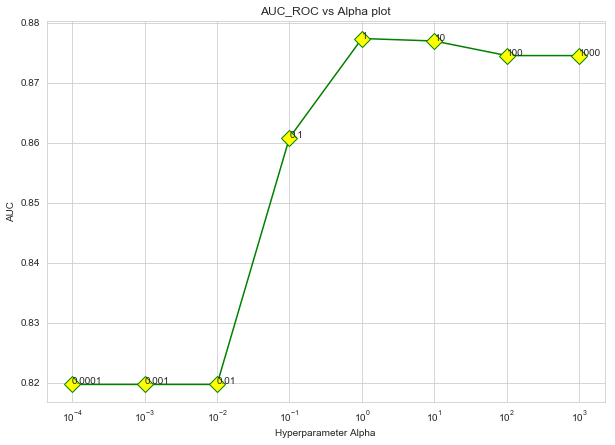

In [132]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

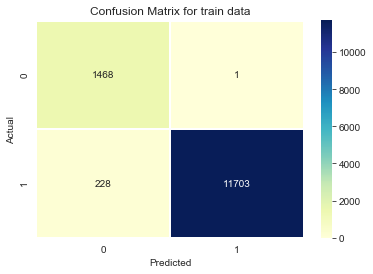

In [133]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = SVC(C=opt_alpha, kernel='rbf',class_weight='balanced')
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_train,svm_optimal.predict(X_train))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

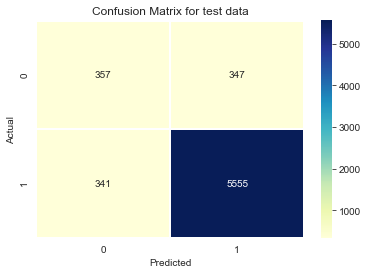

In [134]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = SVC(C=opt_alpha, kernel='rbf',class_weight='balanced')
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,svm_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [135]:
# calculating train_auc
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-4, 4)]
for alp in tqdm(alpha_list):
    clf = SVC(C=alp, kernel='rbf',probability=True,class_weight='balanced')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)
    

100%|██████████| 8/8 [28:53<00:00, 203.52s/it]


In [136]:
# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-4, 4)]
for alp in tqdm(alpha_list):
    clf = SVC(C=alp, kernel='rbf',probability=True, class_weight='balanced')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)

100%|██████████| 8/8 [27:21<00:00, 198.30s/it]


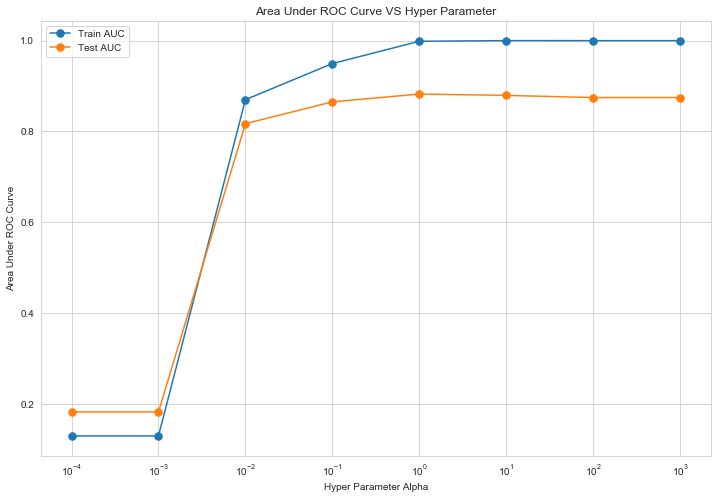

In [137]:
plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [138]:
sv_optimal=SVC(C=opt_alpha, kernel='rbf',class_weight='balanced',probability=True)
sv_optimal.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Train AUC: 0.998468
Test AUC: 0.882394


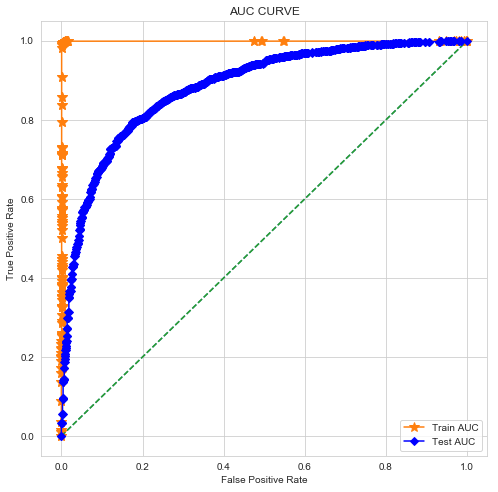

In [139]:
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = sv_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = sv_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()

## Conclusion

In [140]:
tfidf_brute_par2=opt_alpha
tfidf_brute_auc2=np.round(test_auc,4)
print("Vectorizer: TFIDF \t Model: SVM with RBF KERNEL")
print("Best Hyper parameter: ",tfidf_brute_par2)
print("AUC: ",tfidf_brute_auc2)

Vectorizer: TFIDF 	 Model: SVM with RBF KERNEL
Best Hyper parameter:  1.0
AUC:  0.8824


### [5.1.3]  <font color='orange'>Applying RBF SVM on AVG W2V</font>,<font color='red'> SET 3</font>

In [141]:
# Please write all the code with proper documentation

In [142]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test
from sklearn.model_selection import train_test_split

X = preprocessed_reviews
y = final['Score']
X=X[0:20000]
y=y[0:20000]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test= np.split(X, [int(.67 *len(X))])

print('shape of X_train:',len(X_train),'shape of X_test:',len(X_test))

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test

shape of X_train: 13400 shape of X_test: 6600


In [143]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [144]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8740894198417664), ('wonderful', 0.8174455165863037), ('excellent', 0.7953101992607117), ('fantastic', 0.7551245093345642), ('delicious', 0.7441221475601196), ('amazing', 0.7303016185760498), ('love', 0.7242227792739868), ('awesome', 0.7204333543777466), ('quick', 0.7139683961868286), ('tasty', 0.7112969160079956)]
[('question', 0.9692543745040894), ('disappointing', 0.967241644859314), ('greatest', 0.9665356874465942), ('bc', 0.9652302861213684), ('walden', 0.9635728001594543), ('adores', 0.9626369476318359), ('minds', 0.9620593786239624), ('claiming', 0.9619297981262207), ('youth', 0.9617123007774353), ('honestly', 0.9615544676780701)]


In [145]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
print(len(w2v_words))
# length=len(w2v_words)

number of words that occured minimum 5 times  7403
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children', 'tradition']
7403


In [146]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
sent_vectors=np.array(sent_vectors)

100%|██████████| 13400/13400 [00:25<00:00, 519.09it/s]

13400
50


In [147]:
sent_vec_test=[]
sentance_test=[]
for sentance in X_test:
    sentance_test.append(sentance.split())
    

for sent in tqdm(sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vec_test.append(sent_vec)
print(len(sent_vec_test))
print(len(sent_vec_test[0]))
sent_vec_test=np.array(sent_vec_test)

100%|██████████| 6600/6600 [00:14<00:00, 465.88it/s]

6600
50


In [148]:
# Shape of train and test data
print("X_train shape: {0}   y_train shape: {1}".format(len(X_train), len(y_train)))
print("X_test shape:  {0}    y_test shape: {1}".format(len(X_test), len(y_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 13400   y_train shape: 13400
X_test shape:  6600    y_test shape: 6600

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [149]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(sent_vectors)
final_tst=stdslr.transform(sent_vec_test)

In [150]:
X_train=final_cnt
X_test=final_tst

## k-fold Cross Validation

In [151]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
cv_list=[]
alpha_list=[10 ** x for x in range(-4, 4)]
for alp in tqdm(alpha_list):
    clf = SVC(C=alp, kernel='rbf',class_weight='balanced')
    scores=cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc') 
    cv_list.append(scores.mean())

100%|██████████| 8/8 [03:39<00:00, 26.40s/it]


In [152]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-4)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.7388147439782422, 0.7388147439782422, 0.780705808184913, 0.837482597120189, 0.8494538664303594, 0.8290711349311447, 0.7896018591326207, 0.763154764480155]
Maximum auc is:  0.8494538664303594 for alpha= 1.0


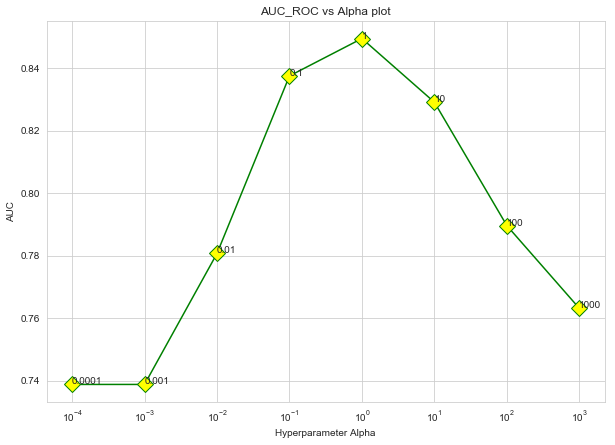

In [153]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

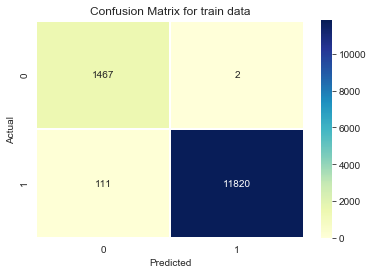

In [154]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = SVC(C=alp, kernel='rbf',class_weight='balanced')
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_train,svm_optimal.predict(X_train))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

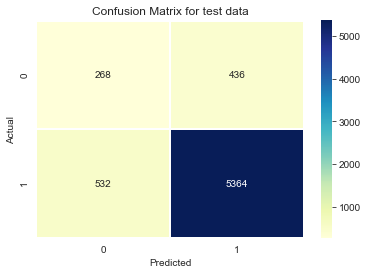

In [155]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = SVC(C=alp, kernel='rbf',class_weight='balanced')
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,svm_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [156]:
# calculating train_auc
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-4, 4)]
for alp in tqdm(alpha_list):
    clf = SVC(C=alp, kernel='rbf',probability=True, class_weight='balanced')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)
    

100%|██████████| 8/8 [16:11<00:00, 115.71s/it]


In [157]:
# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-4, 4)]
for alp in tqdm(alpha_list):
    clf=SVC(C=alp, kernel='rbf',probability=True, class_weight='balanced')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)

100%|██████████| 8/8 [15:20<00:00, 112.27s/it]


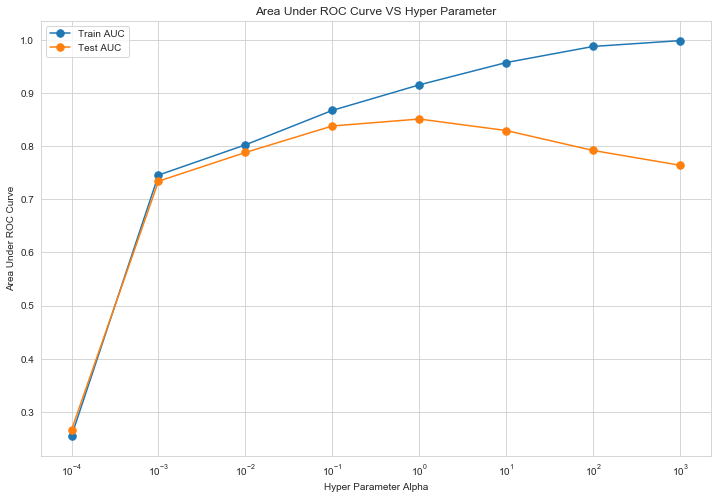

In [158]:
plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [159]:
sv_optimal=SVC(C=alp, kernel='rbf',probability=True, class_weight='balanced')
sv_optimal.fit(X_train,y_train)

SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Train AUC: 0.998509
Test AUC: 0.763899


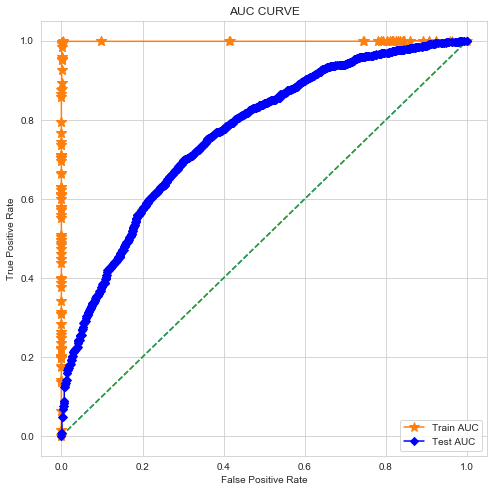

In [160]:
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = sv_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = sv_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()

## Conclusion

In [161]:
avgwv_brute_par2=opt_alpha
avgwv_brute_auc2=np.round(test_auc,4)
print("Vectorizer: AVG W2V \t Model: SVM")
print("Best Hyper parameter: ",avgwv_brute_par2)
print("AUC: ",avgwv_brute_auc2)

Vectorizer: AVG W2V 	 Model: SVM
Best Hyper parameter:  1.0
AUC:  0.7639


### [5.1.4]  <font color='orange'>Applying RBF SVM on TFIDF W2V</font>,<font color='red'> SET 4</font>

In [162]:
# Please write all the code with proper documentation

In [163]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test
# from sklearn.model_selection import train_test_split

X = preprocessed_reviews
y = final['Score']
X=X[0:20000]
y=y[0:20000]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test= np.split(X, [int(.67 *len(X))])

print('shape of X_train:',len(X_train),'shape of X_test:',len(X_test))

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test

shape of X_train: 13400 shape of X_test: 6600


In [164]:
# Shape of train and test data
print("X_train shape: {0}   y_train shape: {1}".format(len(X_train), len(y_train)))
print("X_test shape:  {0}    y_test shape: {1}".format(len(X_test), len(y_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 13400   y_train shape: 13400
X_test shape:  6600    y_test shape: 6600

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [165]:
model = TfidfVectorizer(min_df=10,max_features=500)
tf_idf_matrix = model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [166]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [167]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(tfidf_sent_vectors_train)
final_tst=stdslr.transform(tfidf_sent_vectors_test)

In [168]:
X_train=final_cnt
X_test=final_tst

## k-fold Cross Validation

In [169]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
cv_list=[]
alpha_list=[10 ** x for x in range(-4, 4)]
for alp in tqdm(alpha_list):
    clf = SVC(C=alp, kernel='rbf', class_weight='balanced')
    scores=cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc') 
    cv_list.append(scores.mean())

100%|██████████| 8/8 [03:53<00:00, 29.76s/it]


In [170]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-4)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.7129139098723521, 0.7129139098723521, 0.7469889826450898, 0.8032091743067342, 0.8194413047385893, 0.8027468631791098, 0.7628225167366532, 0.7275619054447118]
Maximum auc is:  0.8194413047385893 for alpha= 1.0


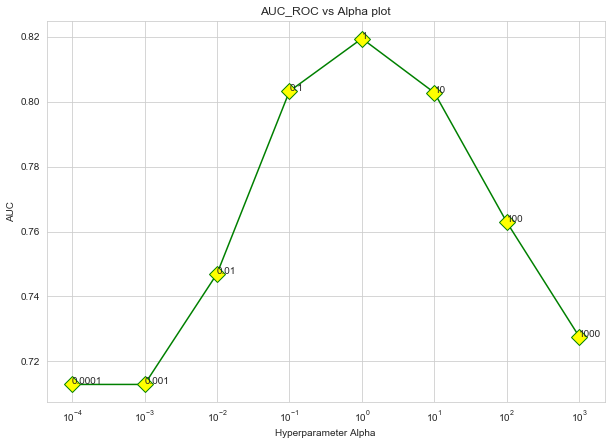

In [171]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

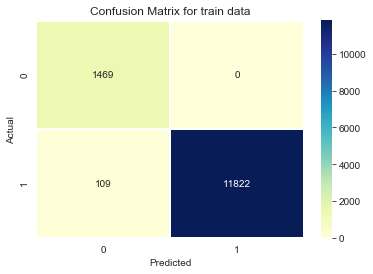

In [172]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = SVC(C=alp, kernel='rbf', class_weight='balanced')
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_train,svm_optimal.predict(X_train))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

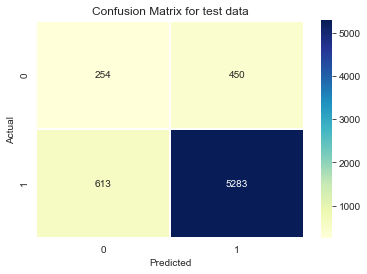

In [173]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = SVC(C=alp, kernel='rbf', class_weight='balanced')
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,svm_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## AUC CURVE

In [174]:
# calculating train_auc
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-4, 4)]
for alp in alpha_list:
    clf = SVC(C=alp, kernel='rbf',probability=True, class_weight='balanced')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)
    

In [175]:
# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-4, 4)]
for alp in alpha_list:
    clf = SVC(C=alp, kernel='rbf',probability=True, class_weight='balanced')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)

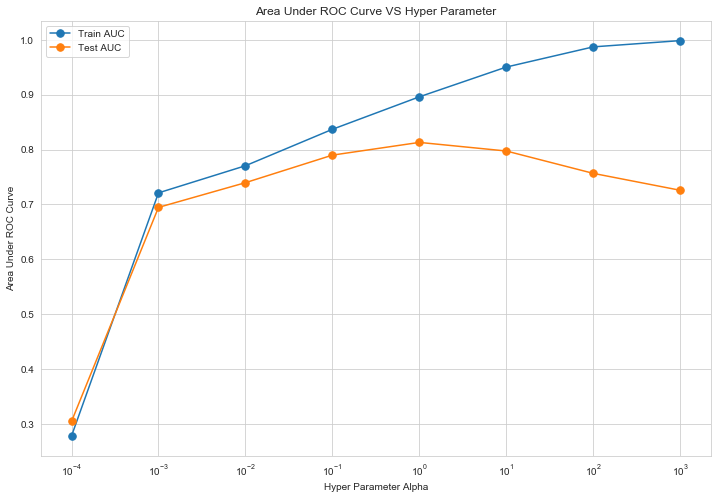

In [177]:
plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [178]:
sv_optimal=SVC(C=alp, kernel='rbf',probability=True, class_weight='balanced')
sv_optimal.fit(X_train,y_train)

SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Train AUC: 0.998169
Test AUC: 0.725845


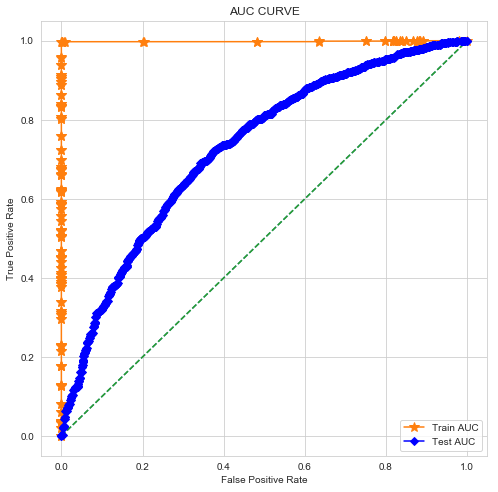

In [179]:
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = sv_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = sv_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()

## Conclusion

In [180]:
tfidfwv_brute_par2=opt_alpha
tfidfwv_brute_auc2=np.round(test_auc,4)
print("Vectorizer: TFIDF W2V \t Model: SVM ")
print("Best Hyper parameter: ",tfidfwv_brute_par2)
print("AUC: ",tfidfwv_brute_auc2)

Vectorizer: TFIDF W2V 	 Model: SVM 
Best Hyper parameter:  1.0
AUC:  0.7258


# <font color='orange'>Feature Engineering</font>

## Combining Summary and Review text

In [181]:
# taking reviws and summary both
from tqdm import tqdm
summary = []
# tqdm is for printing the status bar

for sentance in final['Summary'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    summary.append(sentance.strip())


In [182]:
comb_reviewtxt=[]

for i in range(len(summary)):
    comb_reviewtxt.append(summary[i]+' '+preprocessed_reviews[i])
  

In [183]:
print(summary[1])
print(preprocessed_reviews[1])
print()
print(comb_reviewtxt[1])

whole series great way spend time child
remember seeing show aired television years ago child sister later bought lp day thirty something used series books songs student teaching preschoolers turned whole school purchasing cd along books children tradition lives

whole series great way spend time child remember seeing show aired television years ago child sister later bought lp day thirty something used series books songs student teaching preschoolers turned whole school purchasing cd along books children tradition lives


In [184]:
#hiding all the warnings
warnings.filterwarnings('ignore')

# Breaking the data into train and test


X = comb_reviewtxt
y = final['Score']
data=pd.DataFrame(comb_reviewtxt,columns=['SummaryText'])
data['score']=final['Score']
X_train, X_test= np.split(data, [int(.67 *len(X))])

X_train1=X_train
X_test1=X_test
print('length of X_train:',len(X_train),'length of X_test:',len(X_test))

length of X_train: 46079 length of X_test: 22696


In [185]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train['SummaryText'])
X_train_tfidf= tf_idf_vect.transform(X_train['SummaryText'])

X_test_tfidf=tf_idf_vect.transform(X_test['SummaryText'])

In [186]:
# Shape of train and test data
print("X_train shape: {0} ".format(len(X_train)))
print("X_test shape:  {0} ".format(len(X_test)))

train_per=len(X_train)/len(X)*100
test_per=len(X_test)/len(X)*100
import math
print("\nPercentage of data in Train : {0:.1f} % and Test :{1:.1f} % ".format(train_per,test_per))

X_train shape: 46079 
X_test shape:  22696 

Percentage of data in Train : 67.0 % and Test :33.0 % 


In [187]:
final_counts=X_train_tfidf
final_test=X_test_tfidf

y_train, y_test= np.split(y, [int(.67 *len(y))])
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 46079 
y_test shape:  22696 


In [188]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler(with_mean=False)
final_cnt=stdslr.fit_transform(final_counts)
final_tst=stdslr.transform(final_test)

In [189]:
X_train=final_cnt
X_test=final_tst

y_train, y_test= np.split(y, [int(.67 *len(y))])
y_train1=y_train
y_test1=y_test
print("y_train shape: {0} ".format(len(y_train)))
print("y_test shape:  {0} ".format(len(y_test)))

y_train shape: 46079 
y_test shape:  22696 


In [190]:
# applying logistic regression 
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
cv_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in alpha_list:
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alp, tol=1e-3,class_weight='balanced') 
    scores=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc') # 5 fold cross validation
    cv_list.append(scores.mean())

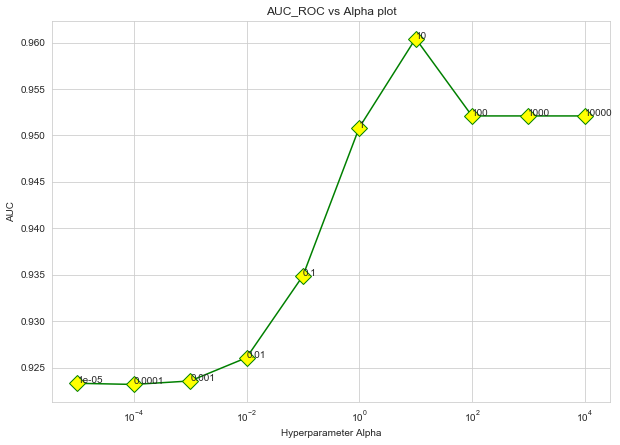

In [191]:
# plot of alpha vs auc_roc
plt.figure(figsize = (10,7))

sns.set_style("whitegrid");

plt.plot(alpha_list, cv_list, color='green',  marker='D',markerfacecolor='yellow', markersize=12)
ind=0
for val in alpha_list:
    plt.annotate('%s' % val,xy=(val,cv_list[ind]),xycoords='data')
    ind=ind+1
plt.xscale('log')
plt.title("AUC_ROC vs Alpha plot")
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('AUC')
plt.show()

In [192]:
# optimal alpha
print(cv_list)
opt_alpha=cv_list.index(max(cv_list))
opt_alpha=math.pow(10,opt_alpha)*math.pow(10,-5)
print("Maximum auc is: ",max(cv_list),"for alpha=",opt_alpha)

[0.923331754949705, 0.9232097165593208, 0.9235843089440758, 0.926087724182883, 0.9348936658225439, 0.95085314552732, 0.9604336239879787, 0.9521026173154141, 0.952101971921428, 0.952101971921428]
Maximum auc is:  0.9604336239879787 for alpha= 10.0


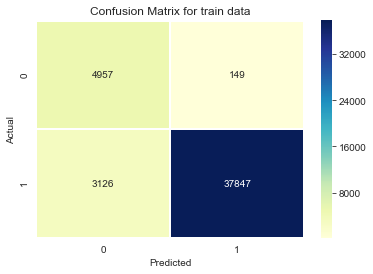

In [193]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3,class_weight='balanced') 
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_train,svm_optimal.predict(X_train))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

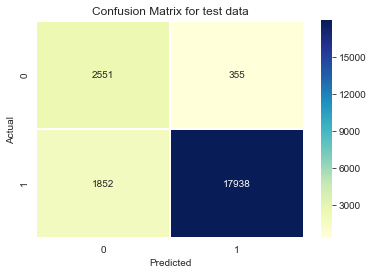

In [194]:
# print(metrics.confusion_matrix(y_test, predicted))

import seaborn as sb
from sklearn.metrics import confusion_matrix
svm_optimal = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3,class_weight='balanced') 
svm_optimal.fit(X_train, y_train)

conf_matrix = confusion_matrix(y_test,svm_optimal.predict(X_test))
df_cmatrix = pd.DataFrame(conf_matrix) #, columns=['Negative', 'Positive'])
sb.heatmap(df_cmatrix, annot=True, fmt='d',cmap="YlGnBu", linewidths=1.4)

plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [195]:
# calculating train_auc
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
cv_list=[]

train_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in alpha_list:
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3,class_weight='balanced') 
    clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_train)
    probs = probs[:,1]
    train_auc = roc_auc_score(y_train, probs)
    train_auc_list.append(train_auc)

In [196]:
# calculating test_auc
from sklearn.metrics import roc_auc_score


cv_list=[]

test_auc_list=[]

alpha_list=[10 ** x for x in range(-5, 5)]
for alp in alpha_list:
    clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3,class_weight='balanced') 
    clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    clf.fit(X_train,y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    test_auc = roc_auc_score(y_test, probs)
    test_auc_list.append(test_auc)

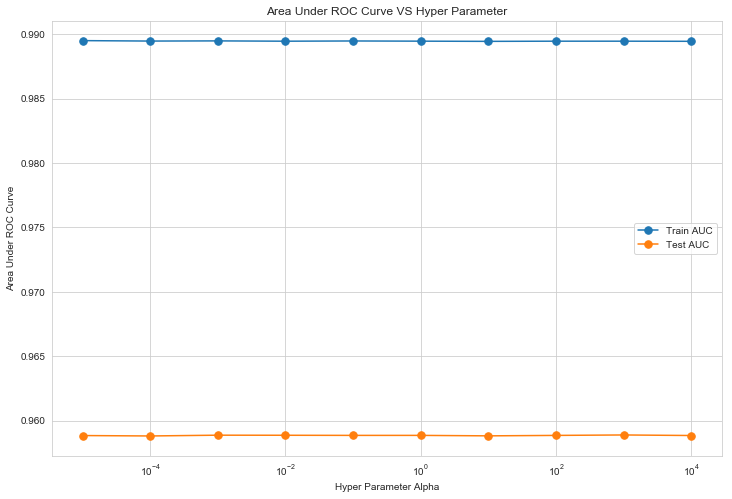

In [197]:
plt.figure(figsize = (12,8))
plt.plot(alpha_list, train_auc_list, marker='.',label="Train AUC",markersize=15)
plt.plot(alpha_list, test_auc_list, marker='.',label="Test AUC",markersize=15)

plt.xscale('log')

plt.legend()
plt.xlabel("Hyper Parameter Alpha")
plt.ylabel("Area Under ROC Curve")
plt.title("Area Under ROC Curve VS Hyper Parameter")
plt.show()

In [198]:
sv_optimal=linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=opt_alpha, tol=1e-3,class_weight='balanced') 
sv_optimal = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
sv_optimal.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10.0, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv=5, method='sigmoid'),
            cv=5, method='sigmoid')

Train AUC: 0.990302
Test AUC: 0.959006


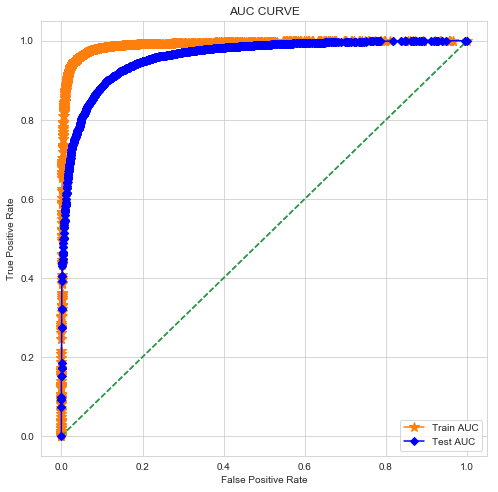

In [199]:
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (8,8))
# predict probabilities
probs = sv_optimal.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
train_auc = roc_auc_score(y_train, probs)
print('Train AUC: %f' % train_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='*',label="Train AUC",markersize=10)


# predict probabilities
probs = sv_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('Test AUC: %f' % test_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='D',color='blue',label="Test AUC",markersize=5)

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC CURVE")

# show the plot
pyplot.show()

In [200]:
tfidf_brute_par3=opt_alpha
tfidf_brute_auc3=np.round(test_auc,4)
print("Vectorizer: TFIDF with Summary and Text Combined \t Model: Logistic Regression")
print("Best Hyper parameter: ",tfidf_brute_par3)
print("AUC: ",tfidf_brute_auc3)

Vectorizer: TFIDF with Summary and Text Combined 	 Model: Logistic Regression
Best Hyper parameter:  10.0
AUC:  0.959


# [6] <font color='orange'>Conclusions</font>

In [201]:
# Constructing a table to summerize all the above results

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", " Hyper Parameter  ", "AUC"]

x.add_row(["BOW", "SVM L1", bow_brute_par, bow_brute_auc])
x.add_row(["BOW", "SVM L2", bow_brute_par2, bow_brute_auc2])
x.add_row(["TFIDF", "SVM L1", tfidf_brute_par, tfidf_brute_auc])
x.add_row(["TFIDF", "SVM L2", tfidf_brute_par2, tfidf_brute_auc2])
x.add_row(["TFIDF with Text & Summary", "SVM L2", tfidf_brute_par3, tfidf_brute_auc3])
x.add_row(["AVG W2V", "SVM L1", avgwv_brute_par, avgwv_brute_auc])
x.add_row(["AVG W2V", "SVM L2", avgwv_brute_par2, avgwv_brute_auc2])
x.add_row(["TFIDF W2V", "SVM L1", tfidfwv_brute_par, tfidfwv_brute_auc])
x.add_row(["TFIDF W2V", "SVM L2", tfidfwv_brute_par2, tfidfwv_brute_auc2])


print("="*100)
print('Conclusions'.center(100,' '))
print("="*100)
print(x.get_string(border=True, padding_width=3))

                                            Conclusions                                             
+-------------------------------+------------+------------------------+------------+
|           Vectorizer          |   Model    |    Hyper Parameter     |    AUC     |
+-------------------------------+------------+------------------------+------------+
|              BOW              |   SVM L1   |          10.0          |   0.8919   |
|              BOW              |   SVM L2   |          1.0           |   0.8718   |
|             TFIDF             |   SVM L1   |          10.0          |   0.9326   |
|             TFIDF             |   SVM L2   |          1.0           |   0.8824   |
|   TFIDF with Text & Summary   |   SVM L2   |          10.0          |   0.959    |
|            AVG W2V            |   SVM L1   |          0.01          |   0.8335   |
|            AVG W2V            |   SVM L2   |          1.0           |   0.7639   |
|           TFIDF W2V           |   SVM L1   |   

# [7] <font color='orange'>Reference</font>

1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
2. https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV
3. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html